In [9]:
import open3d as o3d
import numpy as np
import math
import json

import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion,binary_closing,binary_fill_holes, binary_dilation

x_dim:[44.137805700302124],y_dim:[488.5988712310791],z_dim:[120.12691497802734]


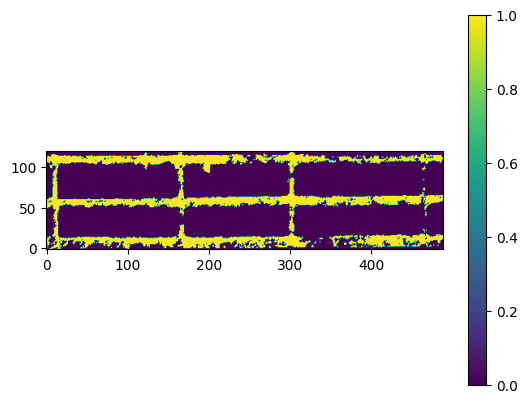

In [10]:
def do_raster(file):
    DECIMALS =1
    Multiplier = 100
    pcd = o3d.io.read_point_cloud(file)
    point_cloud = np.asarray(pcd.points)
    point_cloud= point_cloud*Multiplier
    # point_cloud = point_cloud.round(DECIMALS)
    # point_cloud = point_cloud.round(DECIMALS)
    point_cloud = np.unique(point_cloud,axis=0)
    def get_bounds(np_array ):
        x_min = np.min(np_array[:,0])
        x_max = np.max(np_array[:,0])
        y_min = np.min(np_array[:,1])
        y_max = np.max(np_array[:,1])
        z_min = np.min(np_array[:,2])
        z_max = np.max(np_array[:,2])
        return x_min,x_max,y_min,y_max,z_min,z_max
    def offset(np_array, x, y, z):
        np_array[:,0]=np_array[:,0]-x
        np_array[:,1]=np_array[:,1]-y
        np_array[:,2]=np_array[:,2]-z
        return np_array
        

    def offset_to_zero(np_array):
        x_min,x_max,y_min,y_max,z_min,z_max = get_bounds(np_array)
        return offset(np_array,x_min,y_min,z_min)

    # point_cloud = offset_to_zero(point_cloud)
    x_min,x_max,y_min,y_max,z_min,z_max = get_bounds(point_cloud)
    # print(f"x:[{x_min},{x_max}],y:[{y_min},{y_max}],z:[{z_min},{z_max}]")

    x_dim = x_max#-x_min
    y_dim = y_max#-y_min
    z_dim = z_max#-z_min
    print(f"x_dim:[{x_dim}],y_dim:[{y_dim}],z_dim:[{z_dim}]")

    def create_bitmap(np_array,x_dim,y_dim,z_dim):
        array = np.zeros(shape=(max([int(z_dim)+1]),max([int(y_dim)+1])))
        for row in np_array:
            # print(row)
            array[math.floor(row[2]),math.floor(row[1])] = 1
        return array

    im = create_bitmap(point_cloud,x_dim,y_dim,z_dim)
    # print(im.shape)
    # im = np.rot90(im[:,:])


    
    return im
# im = do_raster("2/2 - compliant.pcd")""
im = do_raster("2/2 - compliant.pcd")
plt.imshow(im,  origin='lower')
plt.colorbar()
plt.show()

In [11]:
def perform_hough(im, im_org, from_angle,to_angle,steps, number_of_lines, min_distance):
    image =im
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    # tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    tested_angles = np.linspace(np.deg2rad(from_angle), np.deg2rad(to_angle), steps, endpoint=True)
    h, theta, d = hough_line(image, theta=tested_angles)

    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray,origin='lower')# 
    ax[0].set_title('Input image')
    # ax[0].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=10)
    # ax[1].tick_params(axis='x', which='major', pad=15)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(im_org, cmap=cm.gray, origin='lower')
    # ax[2].set_ylim((0, image.shape[0]))
    # ax[2].set_xlim((0, image.shape[1]))
    # ax[2].set_axis_off()
    ax[2].set_title('Detected lines')
    res = []
    
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=number_of_lines,min_distance = min_distance)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
        print((x0, y0))
        ax[2].scatter(x=x0, y=y0,c='r')
        slope = angle
        res.append([slope, x0,y0])

    # plt.tight_layout()
    # plt.show()
    return res

def search_along_line(slope, x_0,y_0,im):
    buffer = 10
    slope= slope-np.pi/2
    # print(f"slope: {slope}, ({np.rad2deg(slope)})")
    vector = -(np.array([np.sin(slope),np.cos(slope)]))


    # im = np.pad(im, pad_width=buffer, mode='constant', constant_values=0)
    # res = np.pad(res, pad_width=buffer+1, mode='constant', constant_values=0)
    idx =max(x_0,0)
    idy = max(y_0,0)
    new = np.array([idy,idx])
    res = np.zeros(shape=im.shape)
    # slope = slope+90
  
    # print(f"following vector - {vector}")
    im=im.astype(int)
    
    searcher=np.array(np.round(vector)*5).astype(int) + np.array([10,10])
    # im = np.pad(im, [(int(np.ceil(searcher[1])),),(int(np.ceil(searcher[0])),)], 'constant', constant_values=(0, 0))
    # print(f"searching in vector - {searcher}")
    while 0<= idx <= res.shape[1] and 0<= idy <= res.shape[0]:

        x_low = min(max(int(idx)-searcher[1],0), im.shape[1])
        x_high =min(max(int(idx)+searcher[1],0), im.shape[1])
        y_low = min(max(int(idy)-searcher[0],0), im.shape[0])
        y_high = min(max(int(idy)+searcher[0],0), im.shape[0])
        res[int(idy)-1, int(idx)-1]= np.sum(im[y_low: y_high,x_low: x_high])
        new = new+vector
        idy, idx =np.round(new,0)

        
        
    return res


-------!!!!!!!!!1/1 - faulty.pcd!!!!!!!!!-------
x_dim:[66.55357480049133],y_dim:[621.3513374328613],z_dim:[108.44707489013672]
Looking for 4 poles
(249.52316542707257, -15.433402581860607)
(51.658191042302846, -5.952419527968592)
(579.4354956474687, -25.583322375570756)
Looking for 3 Boards
(0.769523461796242, 96.9969475480633)
(-0.35699542042094157, 44.99858391404999)
len: 110
[[[0, 248], [108, 255]]]
found a pole from [0, 248] -> [108, 255], with len:108.2266141020775
(x_min,y_min) : (248,0) -> (x_max,y_max) : (255,108)
len: 110
[[[0, 50], [108, 63]]]
found a pole from [0, 50] -> [108, 63], with len:108.77959367454909
(x_min,y_min) : (50,0) -> (x_max,y_max) : (63,108)
len: 110
[[[0, 578], [108, 583]]]
found a pole from [0, 578] -> [108, 583], with len:108.11567878897121
(x_min,y_min) : (578,0) -> (x_max,y_max) : (583,108)
Looking for Boards
len: 622
[[[91, 1], [96, 621]]]
found a board from [91, 1] -> [96, 621], with len:620.0201609625287
(x_min,y_min) : (1,91) -> (x_max,y_max) : (6

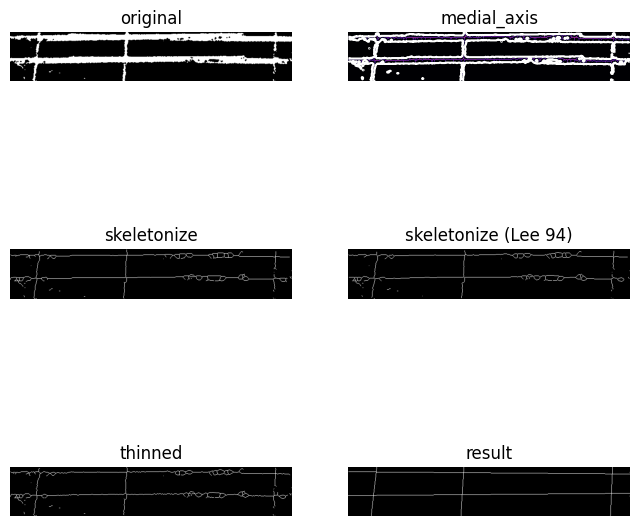

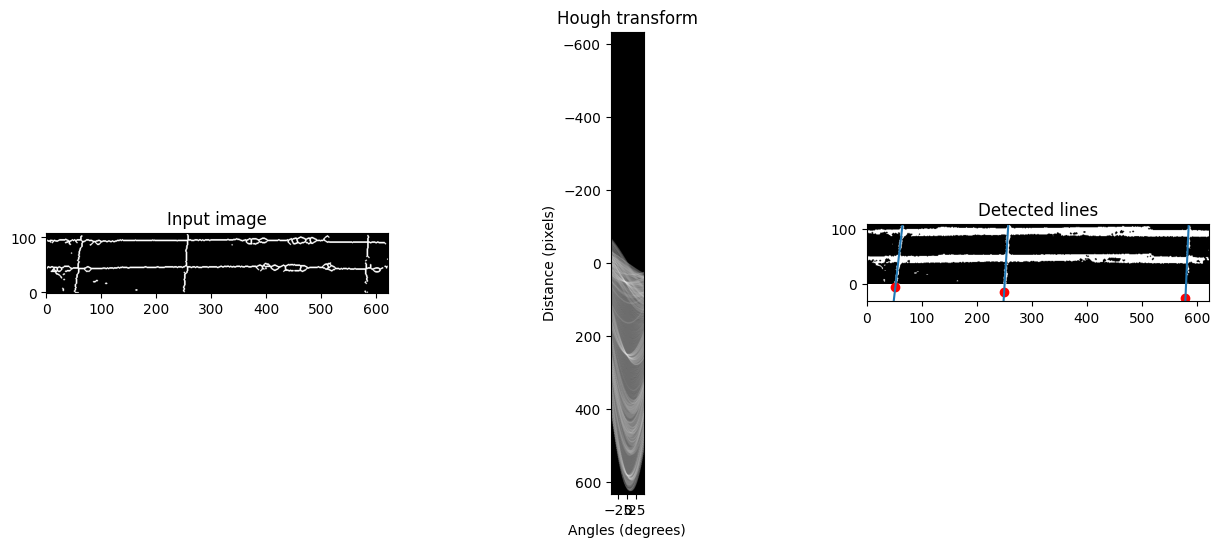

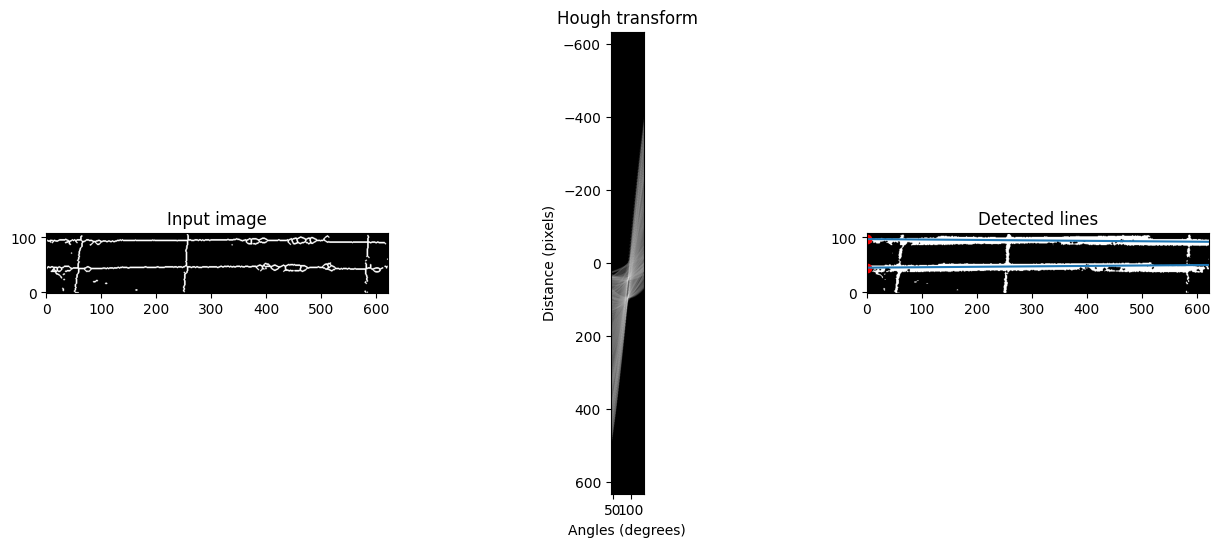

-------!!!!!!!!!2/2 - compliant.pcd!!!!!!!!!-------
x_dim:[44.137805700302124],y_dim:[488.5988712310791],z_dim:[120.12691497802734]
Looking for 4 poles
(11.99953275121427, 0.10589500713489675)
(302.9882019681603, 2.673848930156143)
(167.9411297094583, 4.447128501730437)
Looking for 3 Boards
(-0.4442609676349495, 55.998237759706655)
(-0.8567890090102597, 107.99660139371997)
(0.08726554721400683, 10.999653845656663)
len: 121
[[[0, 10], [119, 11]]]
found a pole from [0, 10] -> [119, 11], with len:119.00420160649792
(x_min,y_min) : (10,0) -> (x_max,y_max) : (11,120)
len: 119
[[[1, 301], [119, 302]]]
found a pole from [1, 301] -> [119, 302], with len:118.00423721205946
(x_min,y_min) : (301,1) -> (x_max,y_max) : (302,120)
len: 118
[[[3, 164], [119, 167]]]
found a pole from [3, 164] -> [119, 167], with len:116.03878661895772
(x_min,y_min) : (164,3) -> (x_max,y_max) : (167,120)
Looking for Boards
len: 490
[[[54, 0], [59, 488]]]
found a board from [54, 0] -> [59, 488], with len:488.025614081884

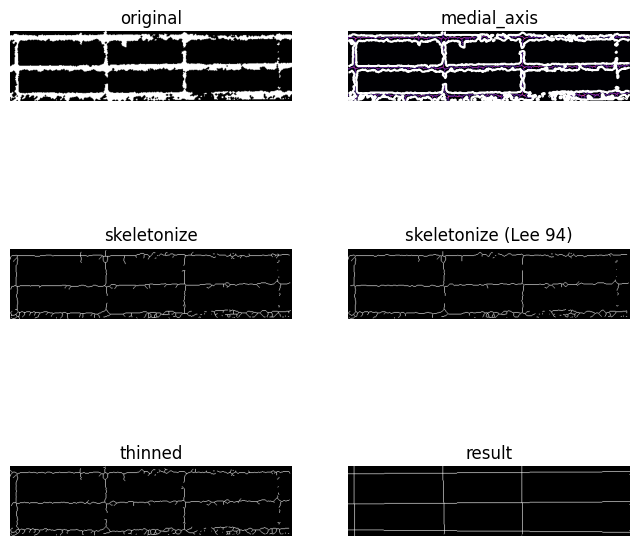

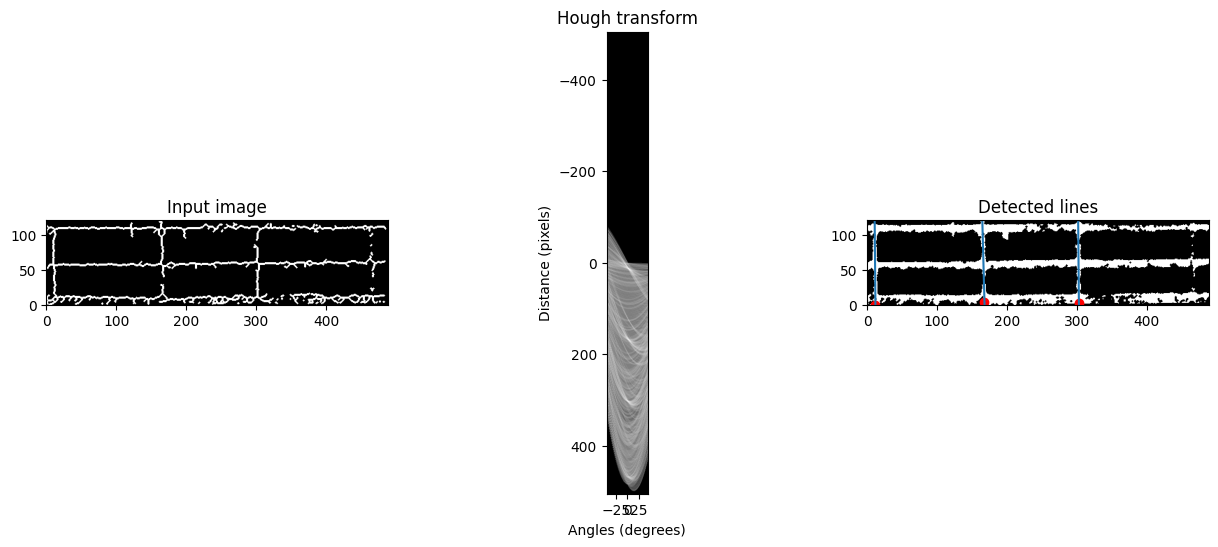

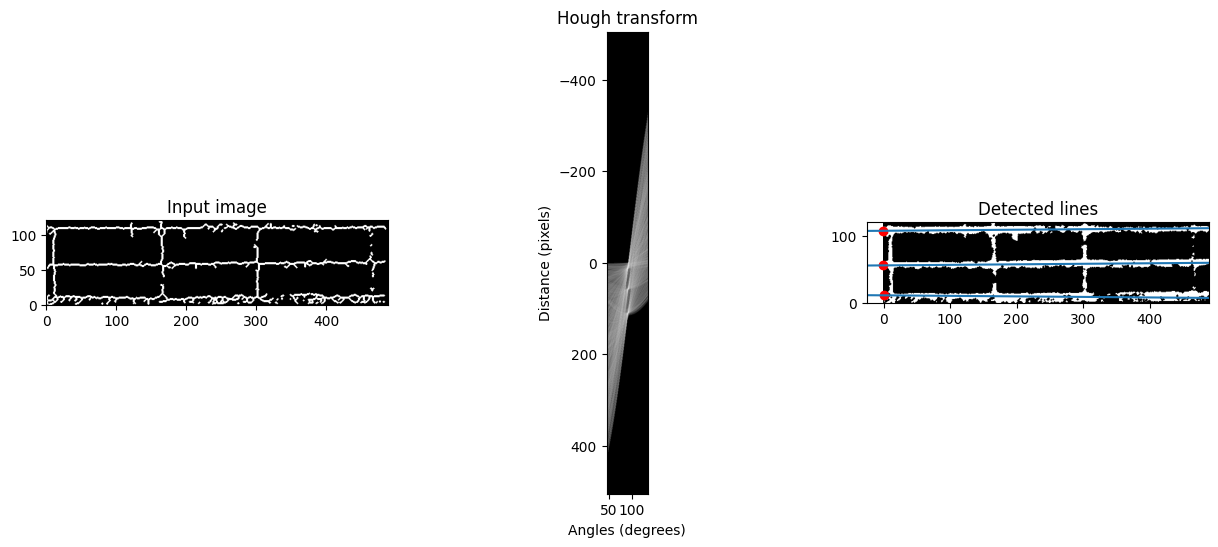

-------!!!!!!!!!2/2 - faulty.pcd!!!!!!!!!-------
x_dim:[71.81985378265381],y_dim:[487.4351978302002],z_dim:[110.48047542572021]
Looking for 4 poles
(457.9821666713446, -4.041659438981892)
(161.99369214139264, 1.429582596321106)
(295.988474529952, -2.612076842660786)
(7.999688500809513, 0.07059667142326449)
Looking for 3 Boards
(1.0470986920287295, 43.98753896649768)
(2.379769754610749, 99.97167946931292)
len: 112
[[[0, 456], [110, 458]]]
found a pole from [0, 456] -> [110, 458], with len:110.01818031580054
(x_min,y_min) : (456,0) -> (x_max,y_max) : (458,110)
len: 111
[[[0, 160], [109, 161]]]
found a pole from [0, 160] -> [109, 161], with len:109.00458705944443
(x_min,y_min) : (160,0) -> (x_max,y_max) : (161,110)
len: 112
[[[0, 294], [110, 296]]]
found a pole from [0, 294] -> [110, 296], with len:110.01818031580054
(x_min,y_min) : (294,0) -> (x_max,y_max) : (296,110)
len: 111
[[[0, 6], [109, 7]]]
found a pole from [0, 6] -> [109, 7], with len:109.00458705944443
(x_min,y_min) : (6,0) -> 

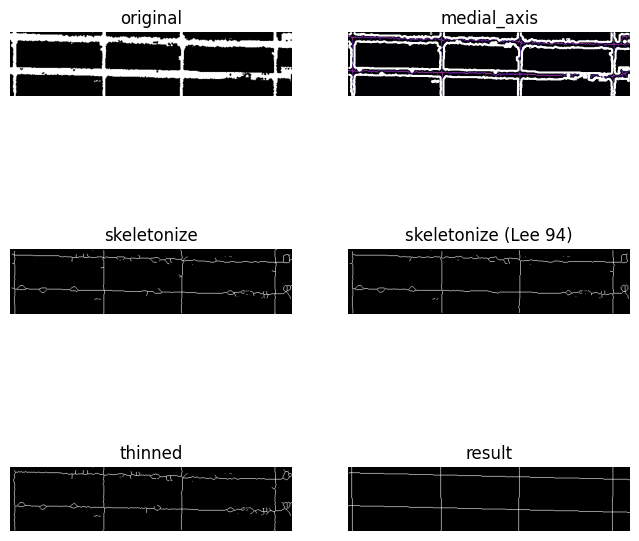

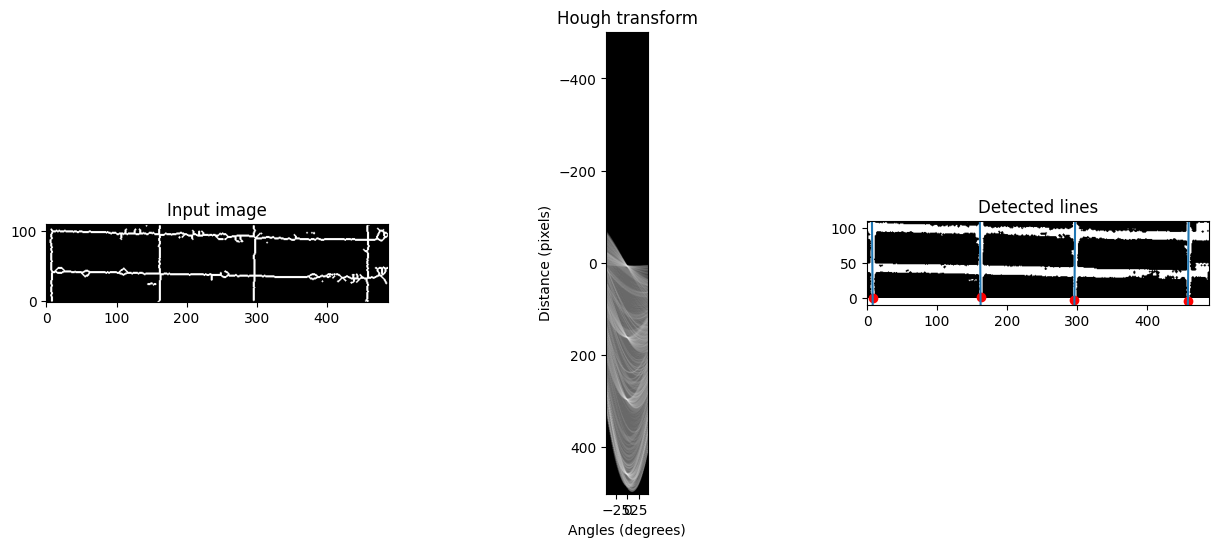

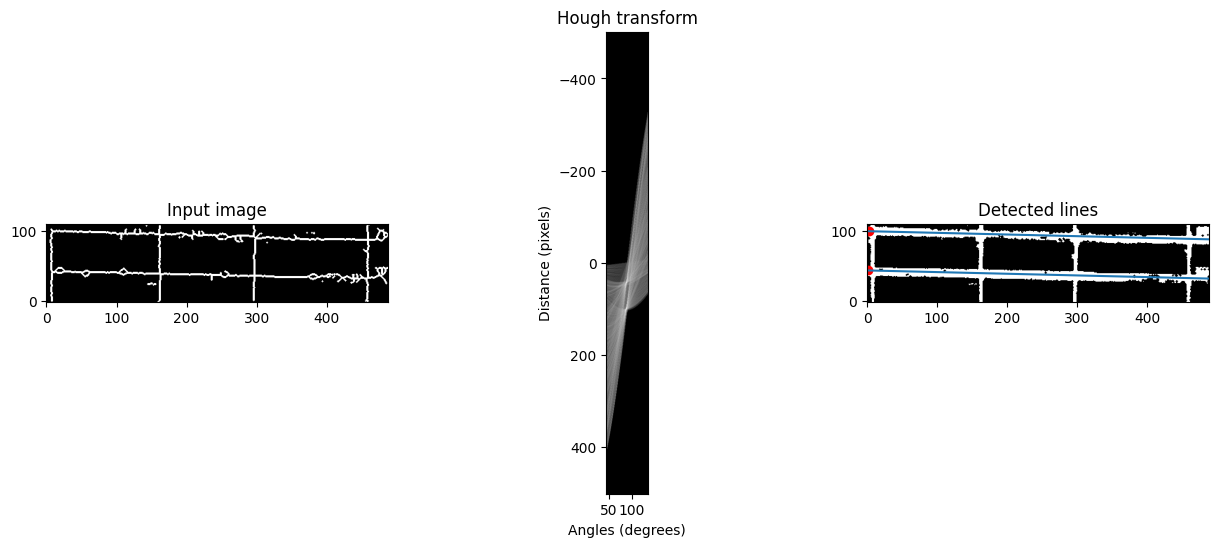

-------!!!!!!!!!2/scen22.pcd!!!!!!!!!-------
x_dim:[183.04157257080078],y_dim:[140.30108451843262],z_dim:[30.711650848388672]
Looking for 4 poles
(57.889374379080834, 3.5805493989916544)
(118.77302674328654, -7.346299628965649)
(1.999299163207837, 0.0529420059729814)
(9.19238815542512, 9.192388155425117)
Looking for 3 Boards
(0.09519877877891654, 11.999622377079998)
len: 28
[[[2, 55], [29, 57]]]
(x_min,y_min) : (55,2) -> (x_max,y_max) : (57,30)
len: 32
[[[0, 117], [30, 120]]]
(x_min,y_min) : (117,0) -> (x_max,y_max) : (120,30)
len: 31
[[[0, 0], [29, 1]]]
(x_min,y_min) : (0,0) -> (x_max,y_max) : (1,30)
len: 14
[[[8, 0], [17, 8]], [[17, 140], [17, 8]]]
found a pole from [17, 140] -> [17, 8], with len:132.0
(x_min,y_min) : (0,8) -> (x_max,y_max) : (140,17)
Looking for Boards
len: 141
[[[10, 0], [11, 139]]]
found a board from [10, 0] -> [11, 139], with len:139.00359707575916
(x_min,y_min) : (0,10) -> (x_max,y_max) : (140,11)


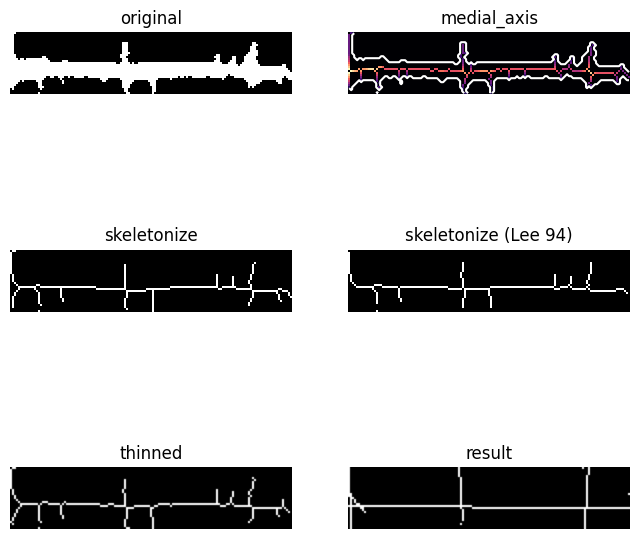

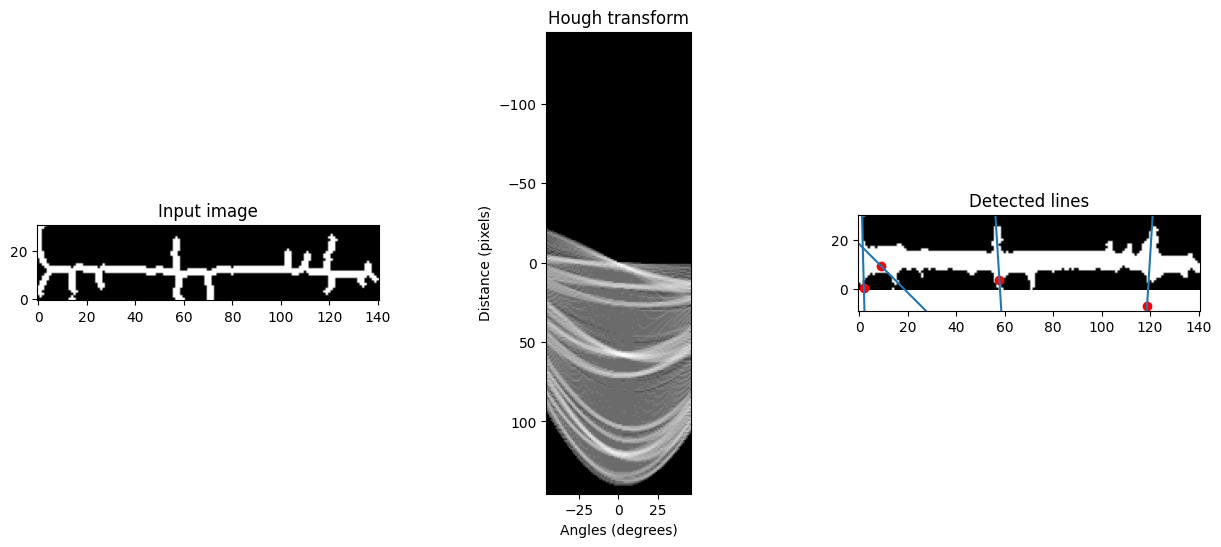

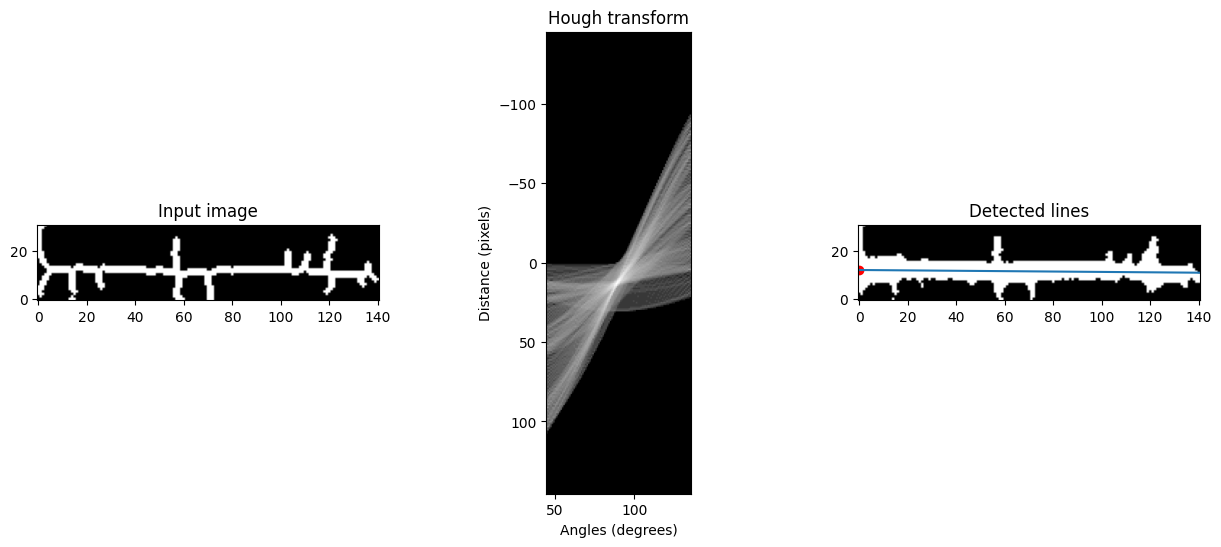

-------!!!!!!!!!3/3 - left.pcd!!!!!!!!!-------
x_dim:[15.890221297740936],y_dim:[143.40773820877075],z_dim:[283.8346242904663]
Looking for 2 poles
(136.9946655763629, -1.2089679981234045)
(7.999688500809513, 0.07059667142326449)
Looking for 1 Boards
(-2.141792779149683, 89.97451152238162)
len: 232
[[[52, 136], [282, 138]]]
found a pole from [52, 136] -> [282, 138], with len:230.00869548780108
(x_min,y_min) : (136,52) -> (x_max,y_max) : (139,283)
len: 232
[[[52, 4], [282, 7]]]
found a pole from [52, 4] -> [282, 7], with len:230.0195643852931
(x_min,y_min) : (4,52) -> (x_max,y_max) : (7,283)
Looking for Boards
len: 145
[[[88, 0], [92, 143]]]
found a board from [88, 0] -> [92, 143], with len:143.05593311708537
(x_min,y_min) : (0,88) -> (x_max,y_max) : (143,92)


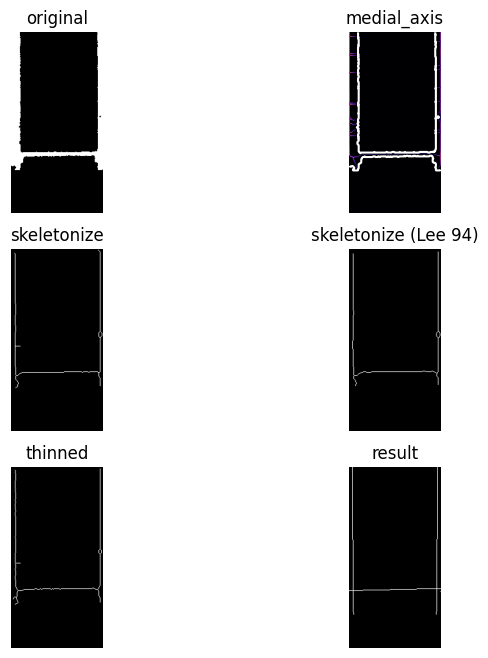

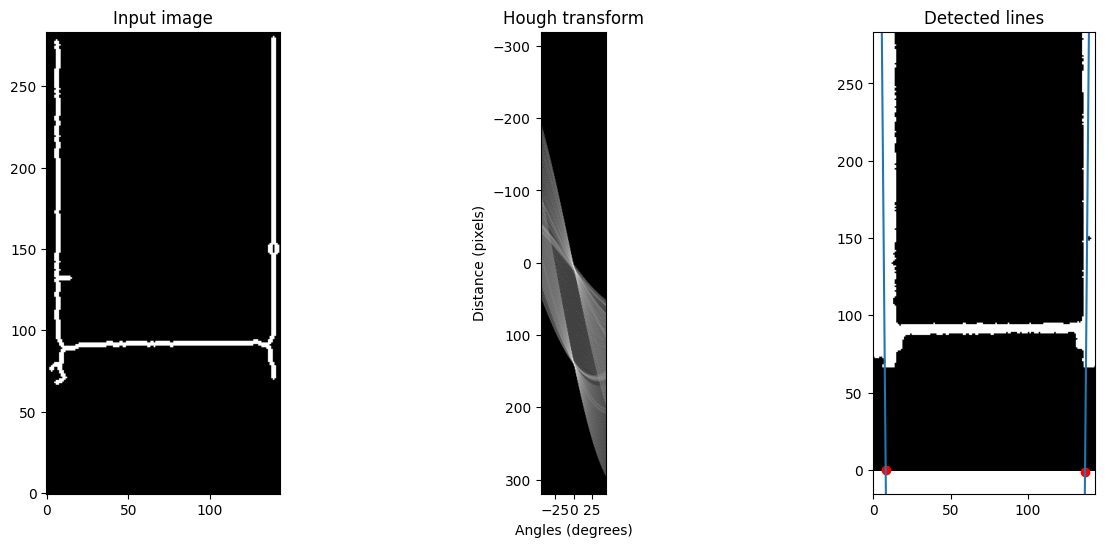

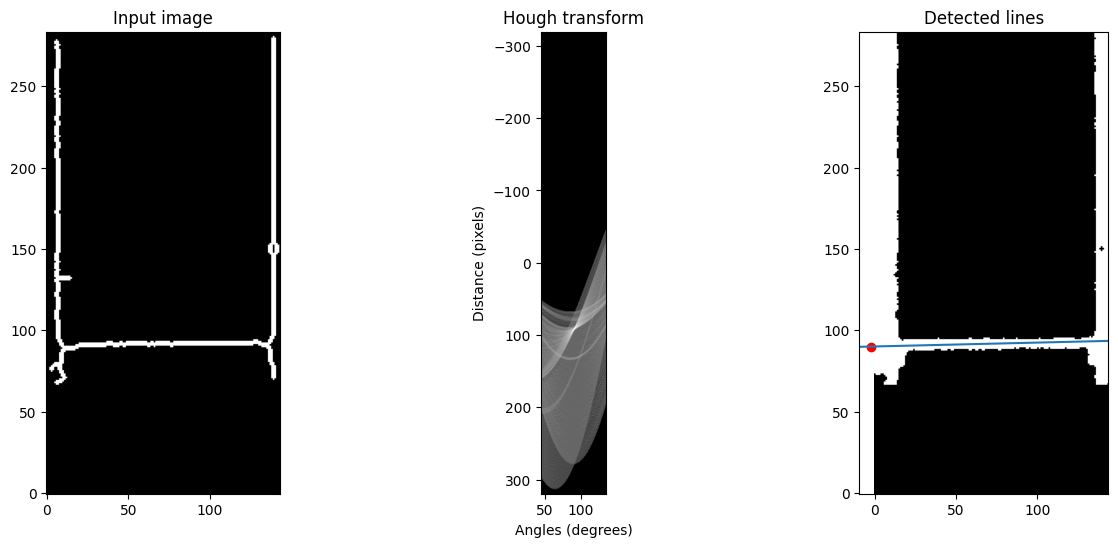

-------!!!!!!!!!3/3 - left_top_cut.pcd!!!!!!!!!-------
x_dim:[14.484627544879913],y_dim:[143.40763092041016],z_dim:[110.91592311859131]
Looking for 2 poles
(10.996145397643103, 0.2911810328513977)
(138.99458770156528, 1.2266171659792207)
Looking for 1 Boards
(-2.141792779149683, 89.97451152238162)
len: 59
[[[52, 7], [109, 9]]]
found a pole from [52, 7] -> [109, 9], with len:57.0350769263968
(x_min,y_min) : (7,52) -> (x_max,y_max) : (9,110)
len: 59
[[[52, 137], [109, 138]]]
found a pole from [52, 137] -> [109, 138], with len:57.0087712549569
(x_min,y_min) : (137,52) -> (x_max,y_max) : (138,110)
Looking for Boards
len: 145
[[[88, 0], [92, 143]]]
found a board from [88, 0] -> [92, 143], with len:143.05593311708537
(x_min,y_min) : (0,88) -> (x_max,y_max) : (143,92)


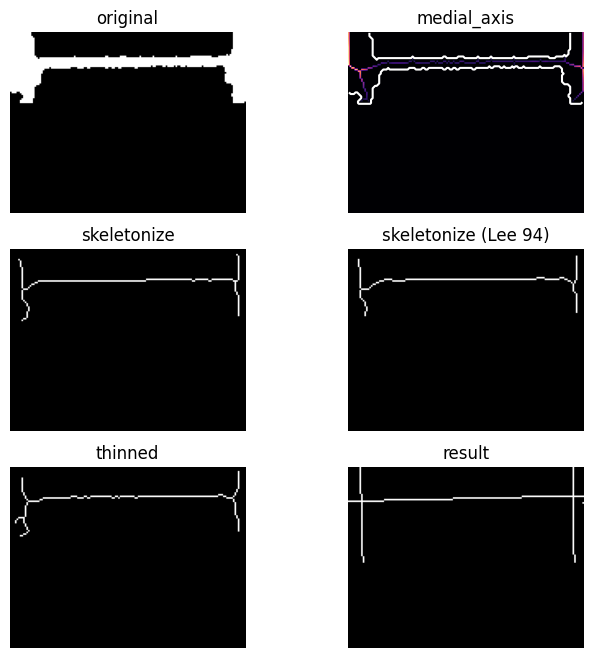

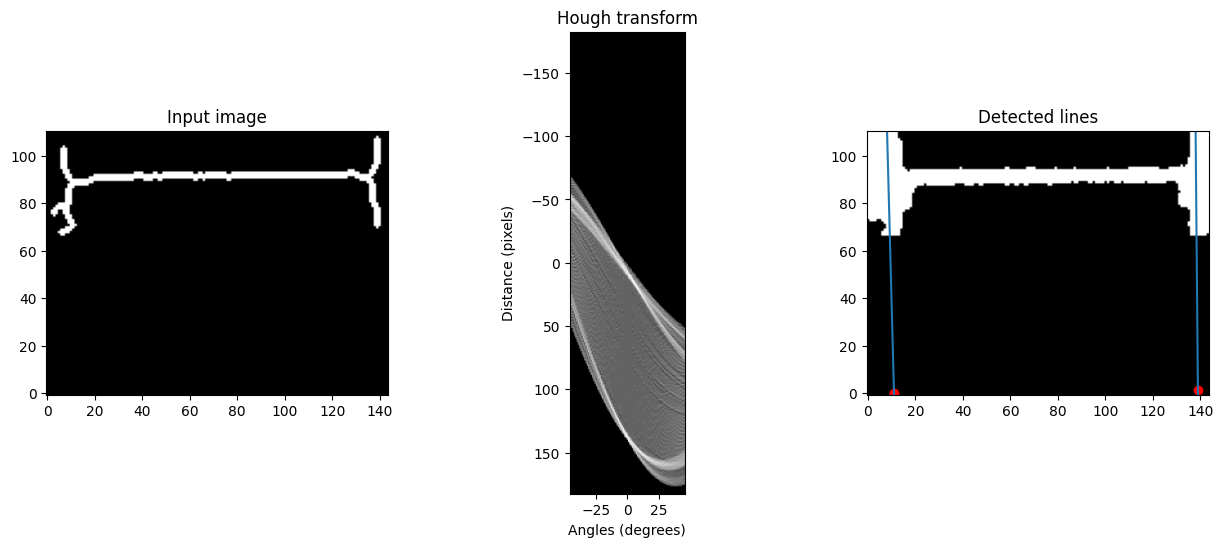

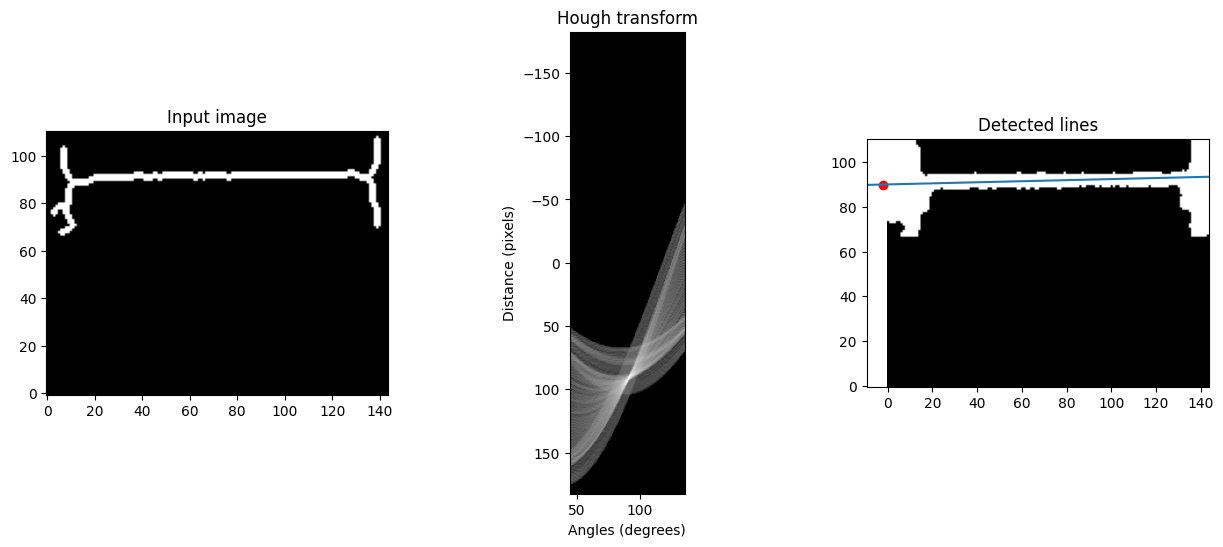

-------!!!!!!!!!3/3 - right.pcd!!!!!!!!!-------
x_dim:[27.24626660346985],y_dim:[137.84180879592896],z_dim:[289.9677038192749]
Looking for 2 poles
(130.99489920075578, -1.156020494555956)
(4.999805313005946, 0.044122919639540306)
Looking for 1 Boards
(-0.6981243777120635, 87.9972307652533)
len: 242
[[[48, 130], [288, 133]]]
found a pole from [48, 130] -> [288, 133], with len:240.01874926763534
(x_min,y_min) : (130,48) -> (x_max,y_max) : (133,289)
len: 242
[[[48, 1], [288, 4]]]
found a pole from [48, 1] -> [288, 4], with len:240.01874926763534
(x_min,y_min) : (1,48) -> (x_max,y_max) : (4,289)
Looking for Boards
len: 139
[[[86, 0], [88, 137]]]
found a board from [86, 0] -> [88, 137], with len:137.01459776242822
(x_min,y_min) : (0,86) -> (x_max,y_max) : (137,88)


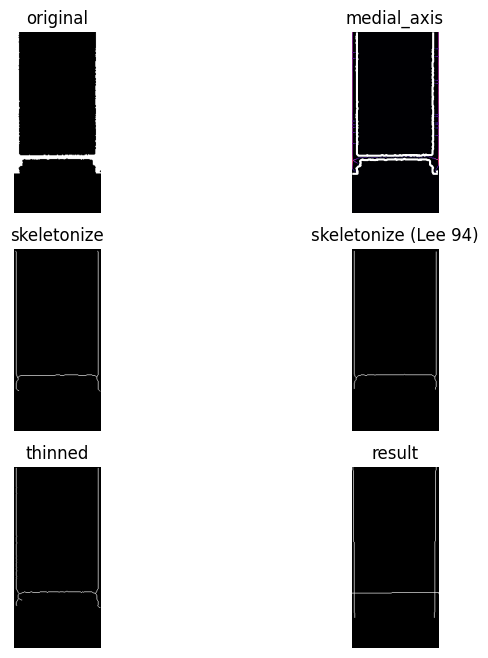

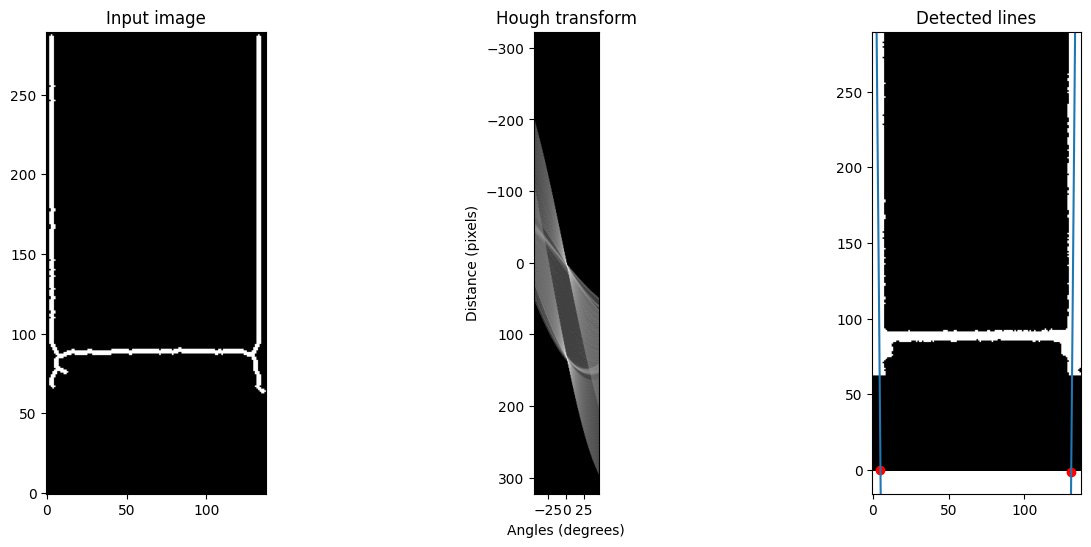

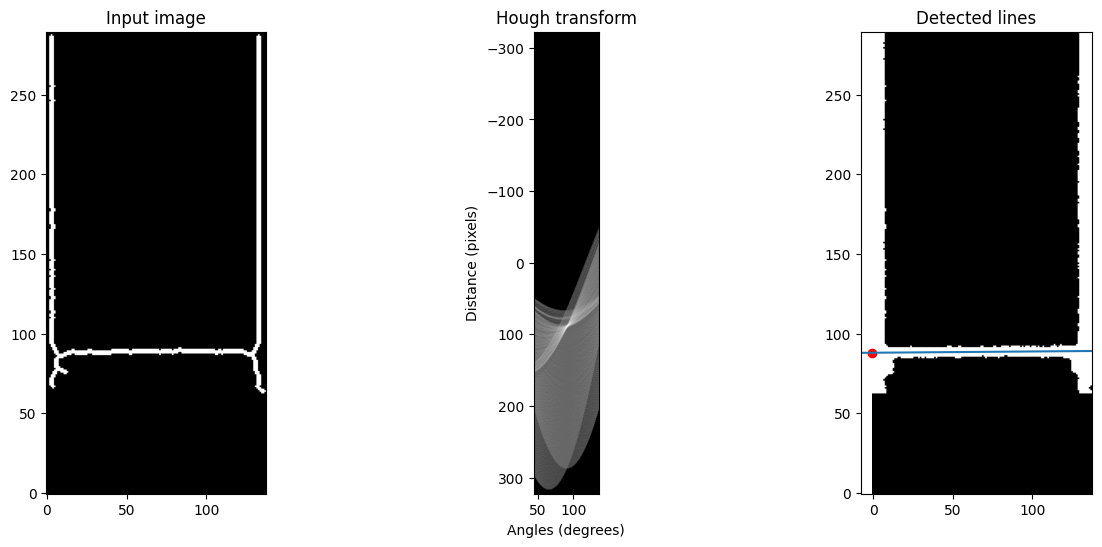

-------!!!!!!!!!4/4 - left.pcd!!!!!!!!!-------
x_dim:[8.954192698001862],y_dim:[135.05228757858276],z_dim:[285.664701461792]
Looking for 2 poles
(133.99478238855934, 1.1824942463396801)
(1.9999221252023782, 0.017649167855816123)
Looking for 1 Boards
(-38.268936496644024, 39.503018864585876)
len: 256
[[[30, 130], [284, 133]]]
found a pole from [30, 130] -> [284, 133], with len:254.01771591761076
(x_min,y_min) : (130,30) -> (x_max,y_max) : (133,285)
len: 253
[[[30, 0], [168, 1]], [[169, 135], [281, 135]]]
found a pole from [30, 0] -> [168, 1], with len:138.00362314084367
found a pole from [169, 135] -> [281, 135], with len:112.0
(x_min,y_min) : (0,30) -> (x_max,y_max) : (135,282)
Looking for Boards
len: 54
[[[38, 0], [56, 18]], [[57, 115], [57, 115]], [[151, 116], [170, 135]]]
(x_min,y_min) : (0,38) -> (x_max,y_max) : (135,171)


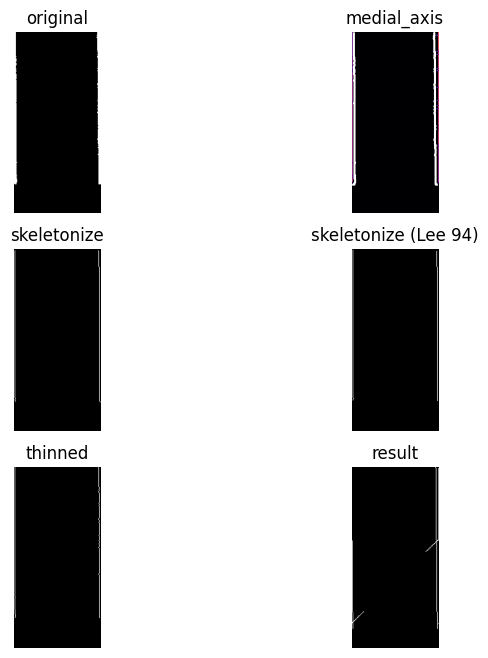

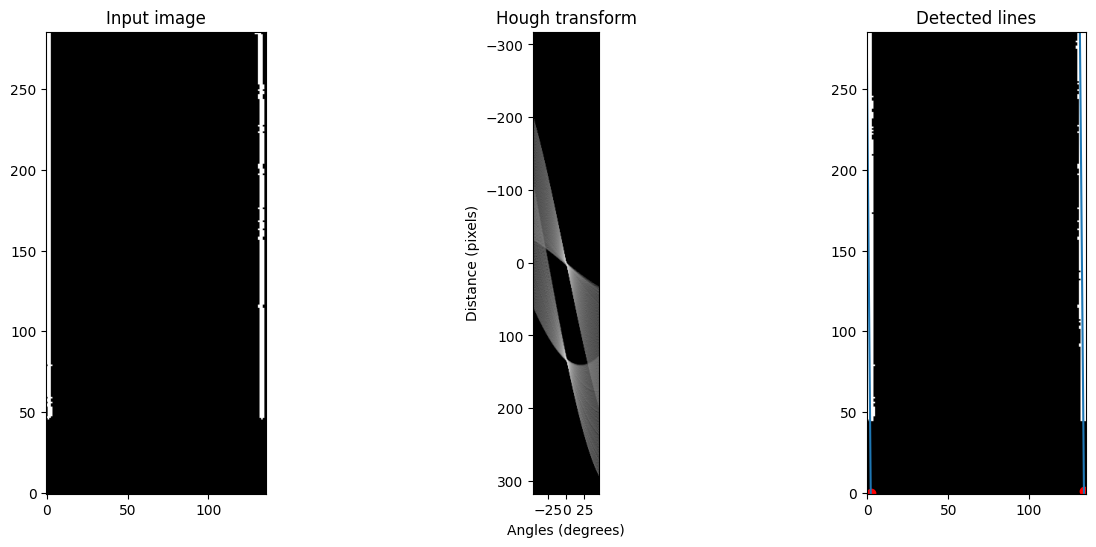

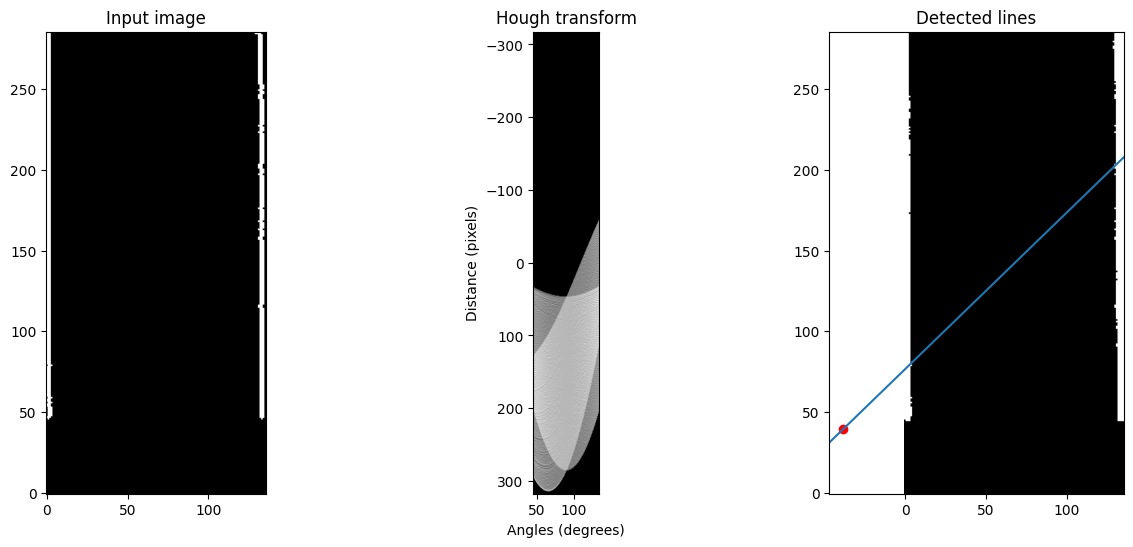

-------!!!!!!!!!4/4 - middle.pcd!!!!!!!!!-------
x_dim:[26.64184272289276],y_dim:[138.40707540512085],z_dim:[286.55948638916016]
Looking for 2 poles
(137.9946266389641, 1.2177925820513125)
(5.999766375607135, 0.05294750356744837)
Looking for 1 Boards
(140.55136676949257, 145.08381473902446)
len: 257
[[[30, 134], [285, 137]]]
found a pole from [30, 134] -> [285, 137], with len:255.01764644824092
(x_min,y_min) : (134,30) -> (x_max,y_max) : (137,286)
len: 257
[[[30, 2], [285, 5]]]
found a pole from [30, 2] -> [285, 5], with len:255.01764644824092
(x_min,y_min) : (2,30) -> (x_max,y_max) : (5,286)
Looking for Boards
No railing found


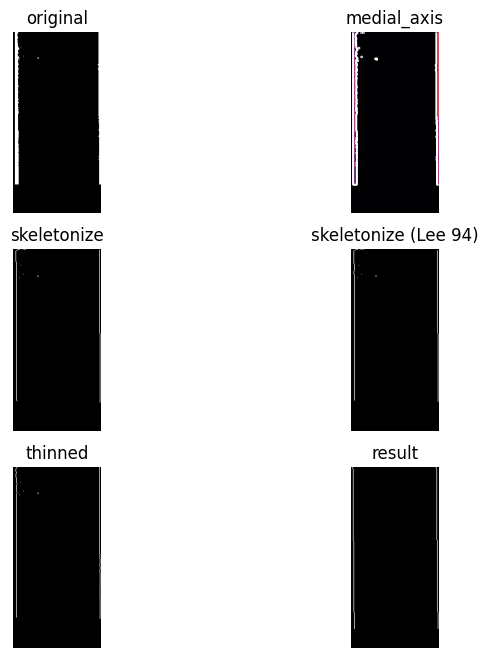

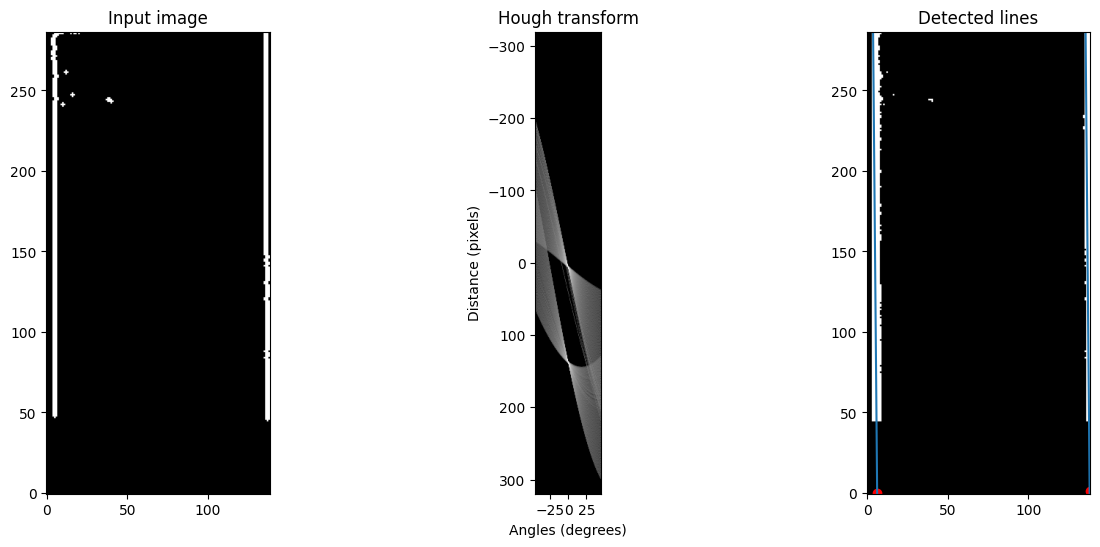

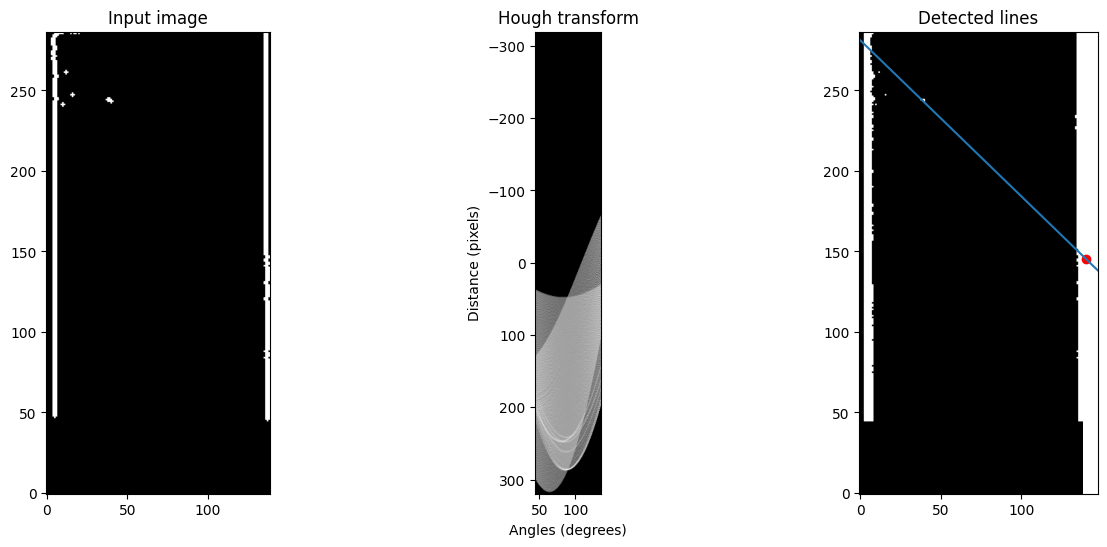

-------!!!!!!!!!4/4 - right.pcd!!!!!!!!!-------
x_dim:[27.726075053215027],y_dim:[138.837468624115],z_dim:[281.84947967529297]
Looking for 2 poles
(136.9946655763629, 1.2089679981234045)
(5.999766375607135, 0.05294750356744837)
Looking for 1 Boards
(139.30003589374988, 139.30003589374985)
len: 252
[[[30, 134], [280, 136]]]
found a pole from [30, 134] -> [280, 136], with len:250.0079998720041
(x_min,y_min) : (134,30) -> (x_max,y_max) : (136,281)
len: 252
[[[30, 3], [280, 5]]]
found a pole from [30, 3] -> [280, 5], with len:250.0079998720041
(x_min,y_min) : (3,30) -> (x_max,y_max) : (5,281)
Looking for Boards
No railing found


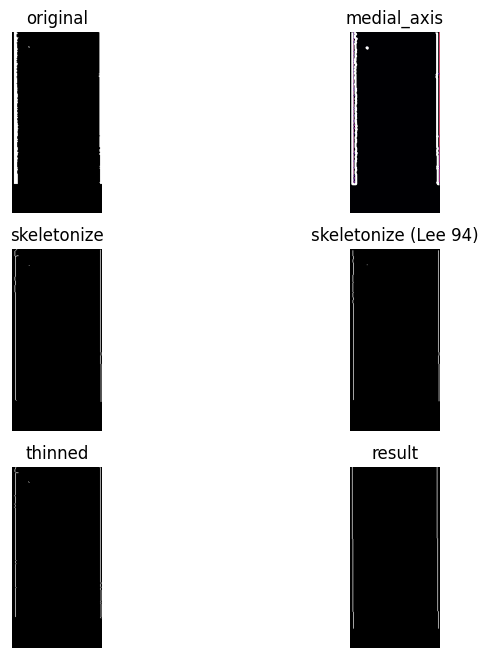

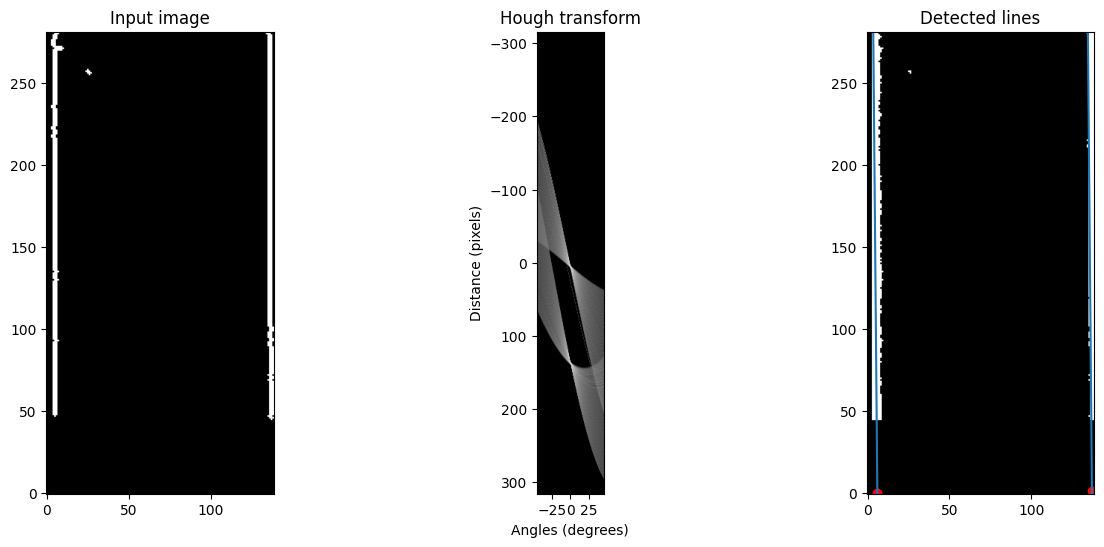

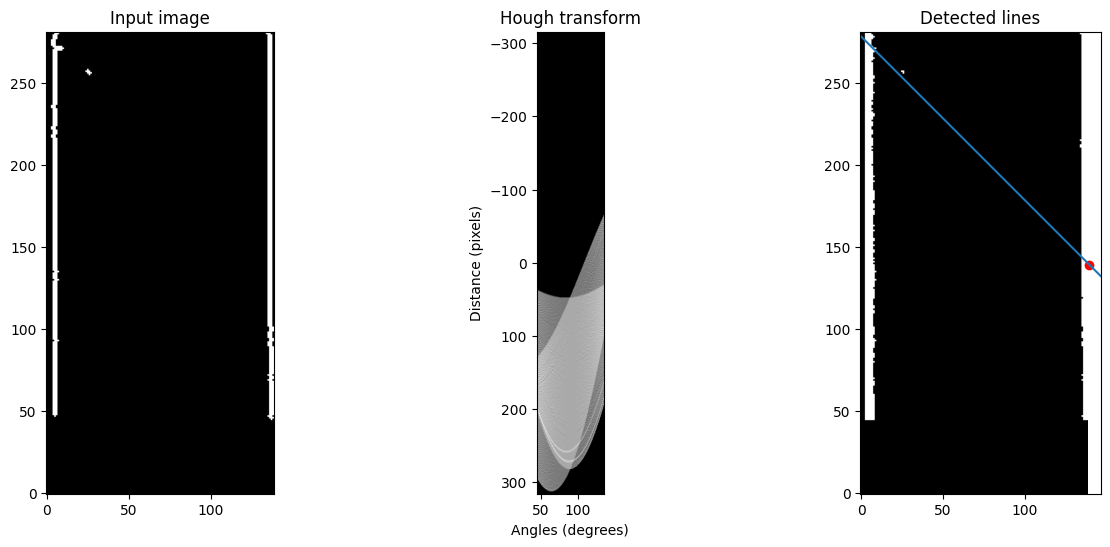

-------!!!!!!!!!6/6_compliant_inside.pcd!!!!!!!!!-------
x_dim:[48.909974098205566],y_dim:[176.06656551361084],z_dim:[173.23570251464844]
Looking for 2 poles
(7.999688500809513, 0.07059667142326449)
(168.99341957960095, 1.4913546838164624)
Looking for 3 Boards
(0.769523461796242, 96.9969475480633)
(0.33319572572620787, 41.99867831977999)
(-0.03966615782454906, 4.999842657116665)
len: 175
[[[0, 5], [173, 7]]]
found a pole from [0, 5] -> [173, 7], with len:173.0115603073968
(x_min,y_min) : (5,0) -> (x_max,y_max) : (7,173)
len: 174
[[[0, 166], [172, 168]]]
found a pole from [0, 166] -> [172, 168], with len:172.01162751395617
(x_min,y_min) : (166,0) -> (x_max,y_max) : (168,173)
Looking for Boards
len: 176
[[[95, 1], [96, 175]]]
found a board from [95, 1] -> [96, 175], with len:174.0028735394907
(x_min,y_min) : (1,95) -> (x_max,y_max) : (176,96)
len: 177
[[[40, 0], [41, 175]]]
found a board from [40, 0] -> [41, 175], with len:175.0028571195339
(x_min,y_min) : (0,40) -> (x_max,y_max) : (176,

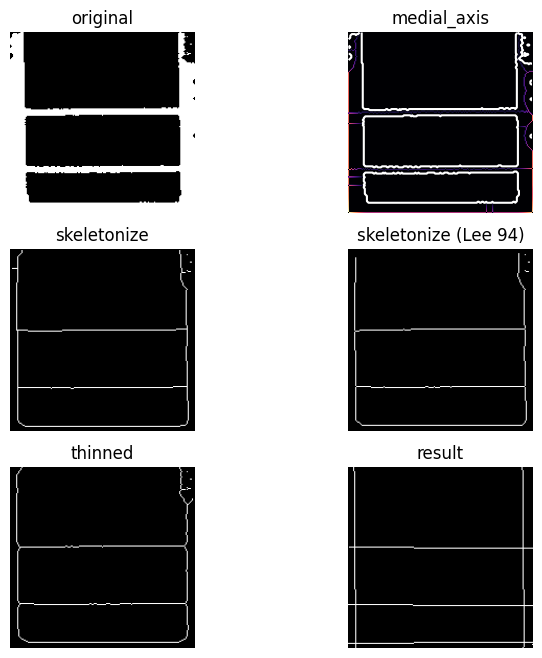

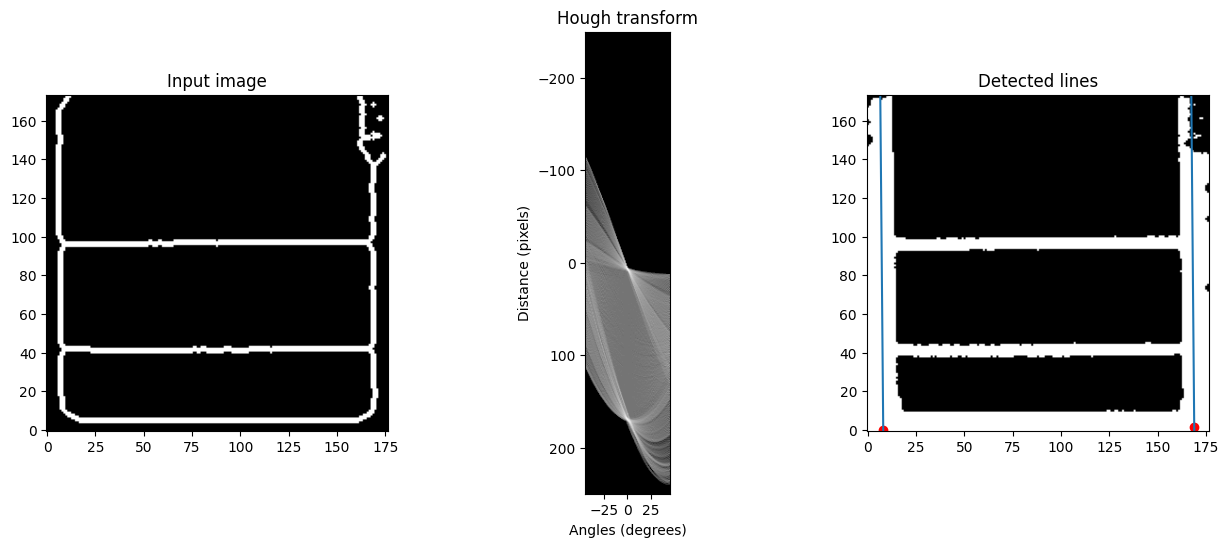

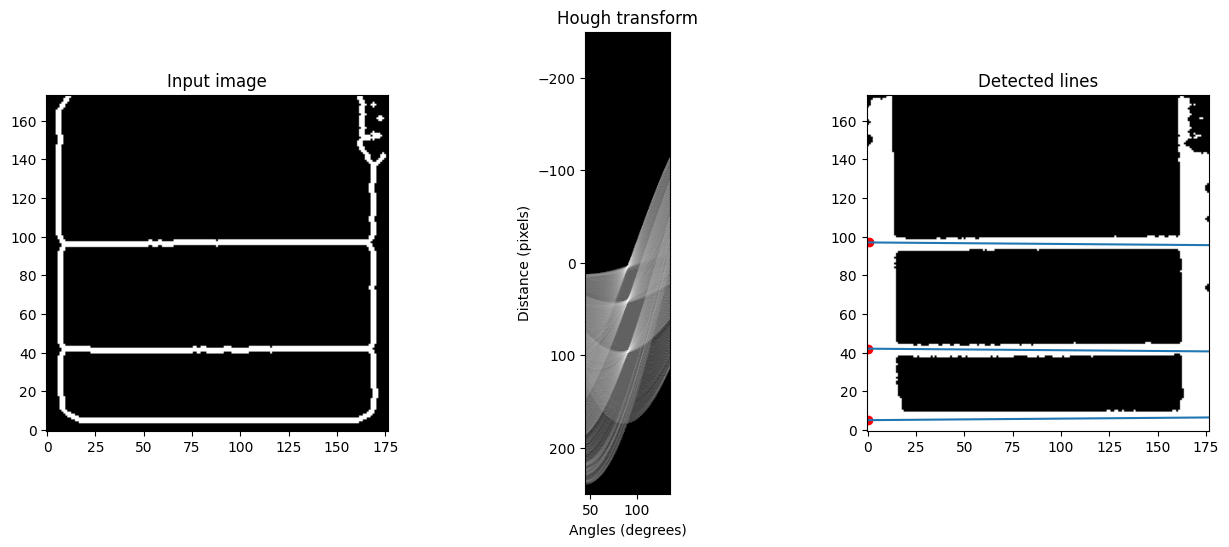

-------!!!!!!!!!6/6_compliant_outside.pcd!!!!!!!!!-------
x_dim:[54.050225019454956],y_dim:[161.4801049232483],z_dim:[215.2752161026001]
Looking for 2 poles
(3.9998442504047564, 0.035298335711632246)
(153.94603556700343, -4.076534459919568)
Looking for 3 Boards
(0.7774566933611518, 97.99691607948664)
(0.3490621888560273, 43.99861538262665)
(0.05553262095436798, 6.999779719963332)
len: 217
[[[0, 1], [215, 3]]]
found a pole from [0, 1] -> [215, 3], with len:215.00930212434997
(x_min,y_min) : (1,0) -> (x_max,y_max) : (3,215)
len: 217
[[[0, 152], [215, 159]]]
found a pole from [0, 152] -> [215, 159], with len:215.11392330576837
(x_min,y_min) : (152,0) -> (x_max,y_max) : (159,215)
Looking for Boards
len: 161
[[[96, 1], [97, 160]]]
found a board from [96, 1] -> [97, 160], with len:159.00314462299164
(x_min,y_min) : (1,96) -> (x_max,y_max) : (161,97)
len: 162
[[[42, 0], [43, 160]]]
found a board from [42, 0] -> [43, 160], with len:160.00312496948303
(x_min,y_min) : (0,42) -> (x_max,y_max) : (

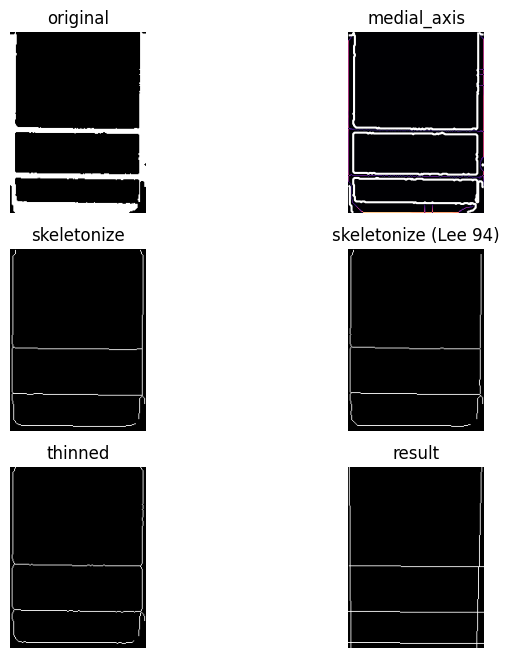

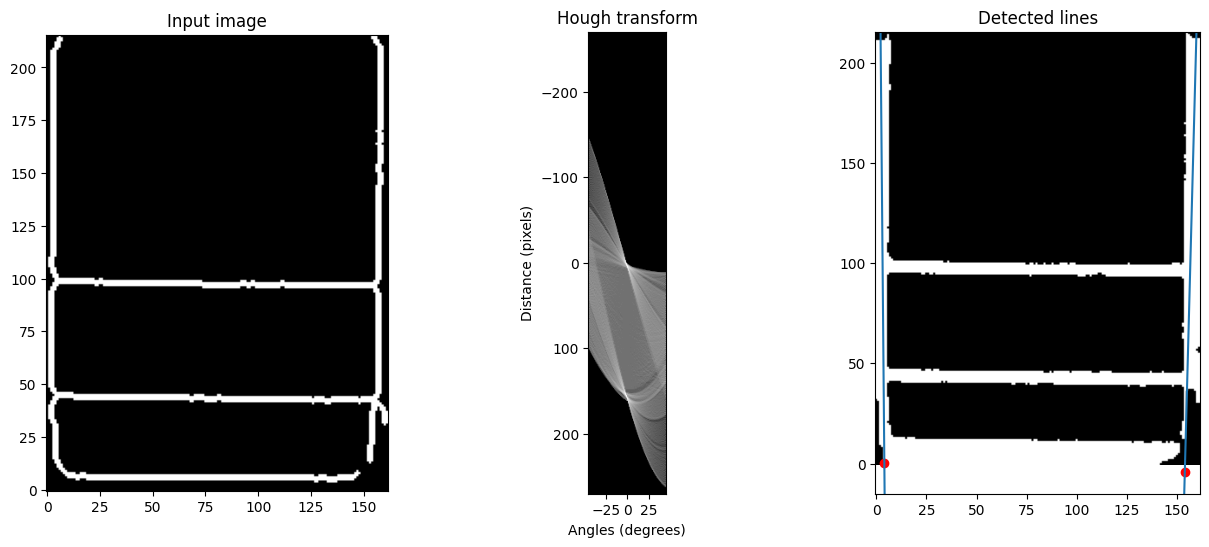

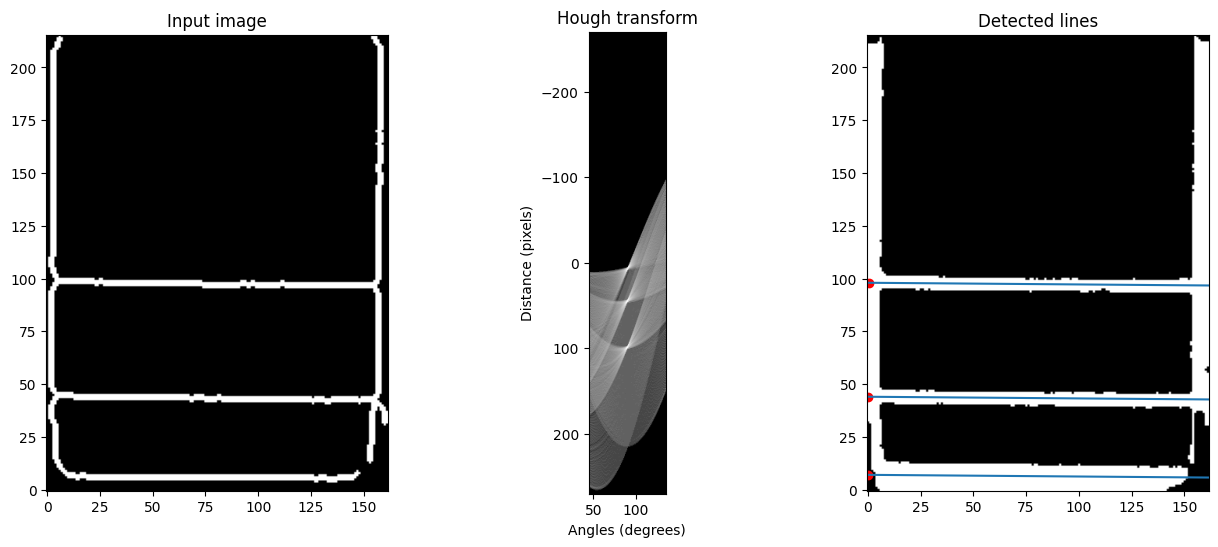

-------!!!!!!!!!6/6_faulty_inside.pcd!!!!!!!!!-------
x_dim:[43.73619556427002],y_dim:[165.53733348846436],z_dim:[206.35833740234375]
Looking for 2 poles
(161.99369214139264, 1.429582596321106)
(5.999766375607135, -0.05294750356744837)
Looking for 3 Boards
(0.7615902302313323, 95.99697901663998)
(0.04759938938945827, 5.999811188539999)
len: 207
[[[0, 159], [205, 161]]]
found a pole from [0, 159] -> [205, 161], with len:205.00975586542216
(x_min,y_min) : (159,0) -> (x_max,y_max) : (161,206)
len: 208
[[[0, 4], [206, 7]]]
found a pole from [0, 4] -> [206, 7], with len:206.0218435020908
(x_min,y_min) : (4,0) -> (x_max,y_max) : (7,206)
Looking for Boards
len: 165
[[[94, 1], [95, 164]]]
found a board from [94, 1] -> [95, 164], with len:163.00306745579974
(x_min,y_min) : (1,94) -> (x_max,y_max) : (165,95)
len: 166
[[[4, 0], [5, 164]]]
found a board from [4, 0] -> [5, 164], with len:164.00304875214974
(x_min,y_min) : (0,4) -> (x_max,y_max) : (165,5)


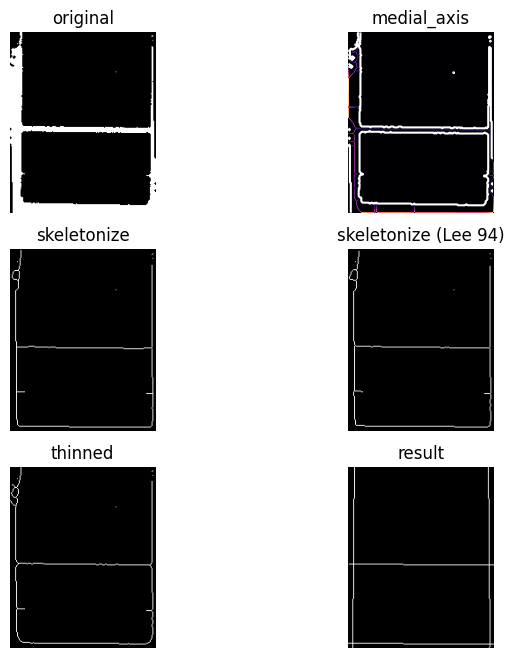

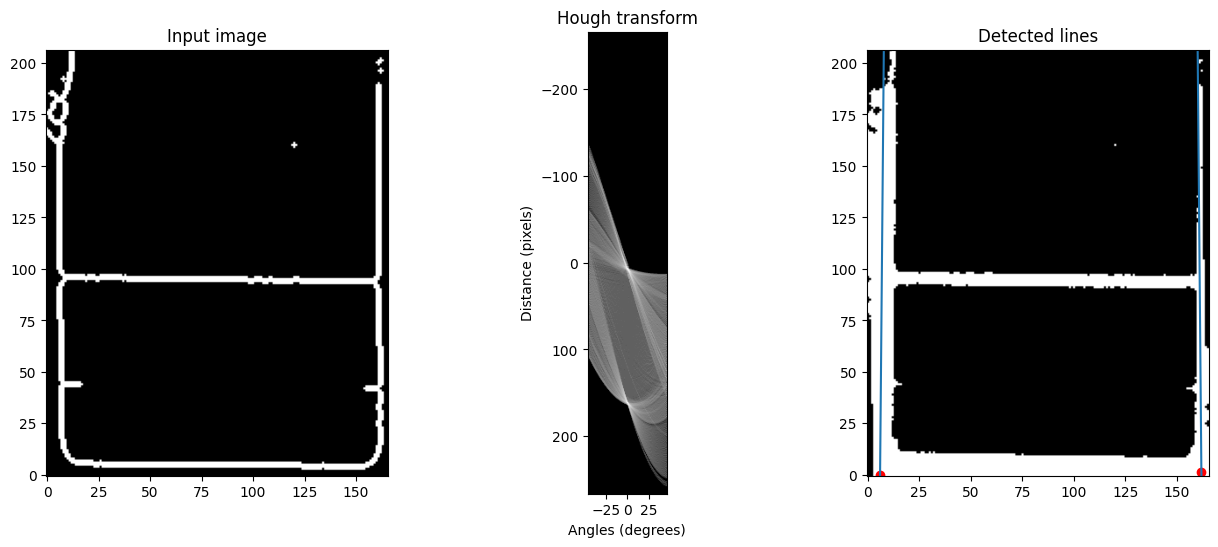

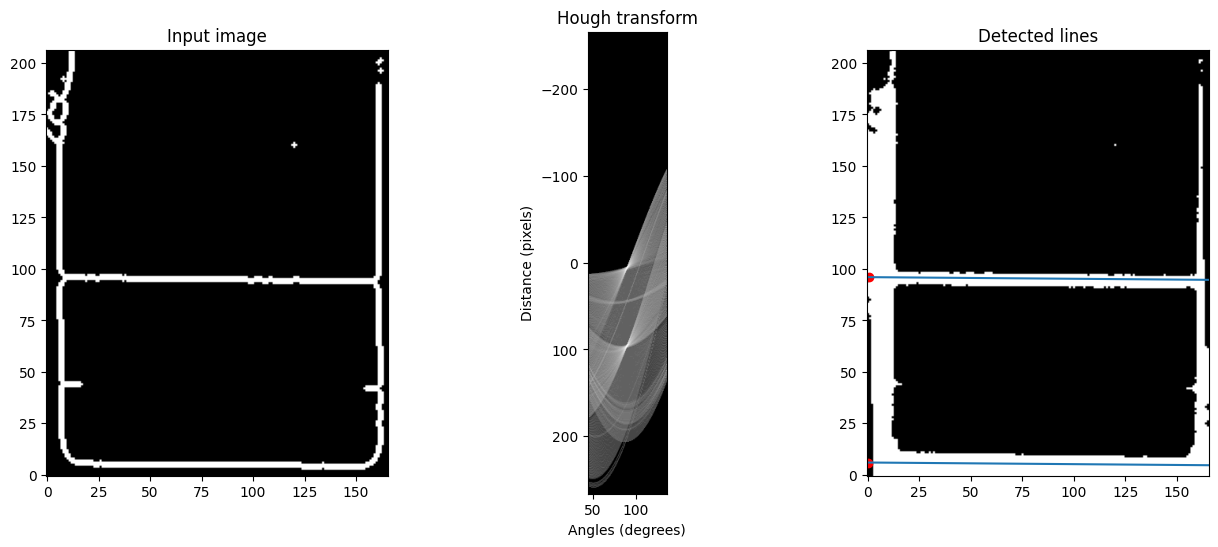

-------!!!!!!!!!6/6_faulty_outside.pcd!!!!!!!!!-------
x_dim:[57.116031646728516],y_dim:[171.5060830116272],z_dim:[216.91796779632568]
Looking for 2 poles
(8.996846234435266, 0.23823902687841628)
(163.99361426659502, 1.4472317641769221)
Looking for 3 Boards
(-0.7695234617962518, 96.9969475480633)
(-0.047599389389458874, 5.999811188539999)
len: 218
[[[0, 2], [216, 8]]]
found a pole from [0, 2] -> [216, 8], with len:216.08331726442927
(x_min,y_min) : (2,0) -> (x_max,y_max) : (8,216)
len: 217
[[[0, 161], [215, 163]]]
found a pole from [0, 161] -> [215, 163], with len:215.00930212434997
(x_min,y_min) : (161,0) -> (x_max,y_max) : (163,216)
Looking for Boards
len: 173
[[[95, 0], [97, 171]]]
found a board from [95, 0] -> [97, 171], with len:171.011695506477
(x_min,y_min) : (0,95) -> (x_max,y_max) : (171,97)
len: 173
[[[4, 0], [6, 171]]]
found a board from [4, 0] -> [6, 171], with len:171.011695506477
(x_min,y_min) : (0,4) -> (x_max,y_max) : (171,6)


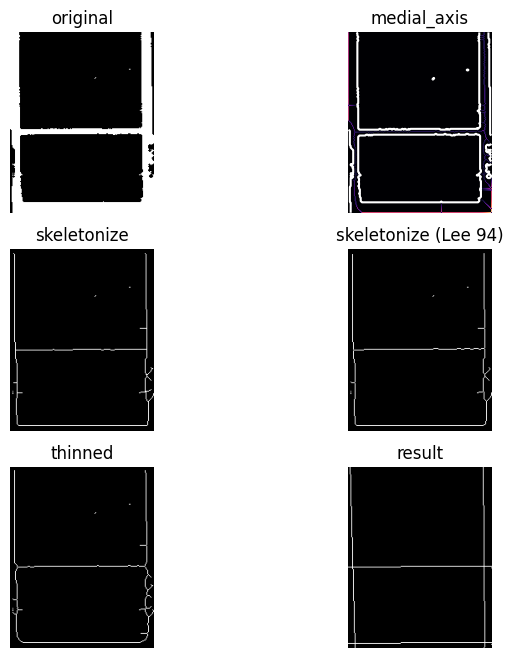

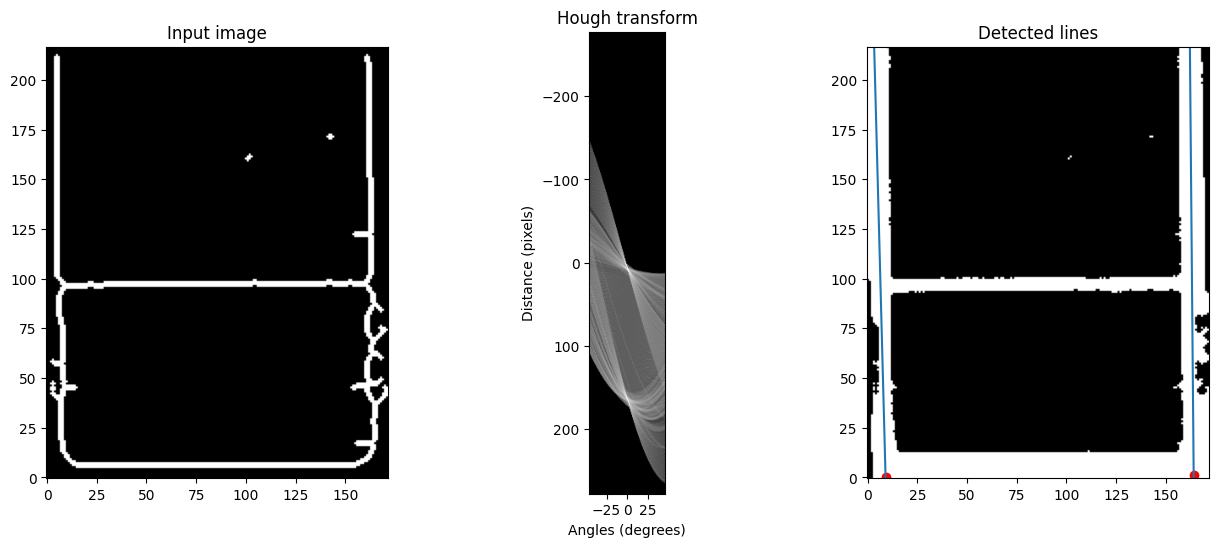

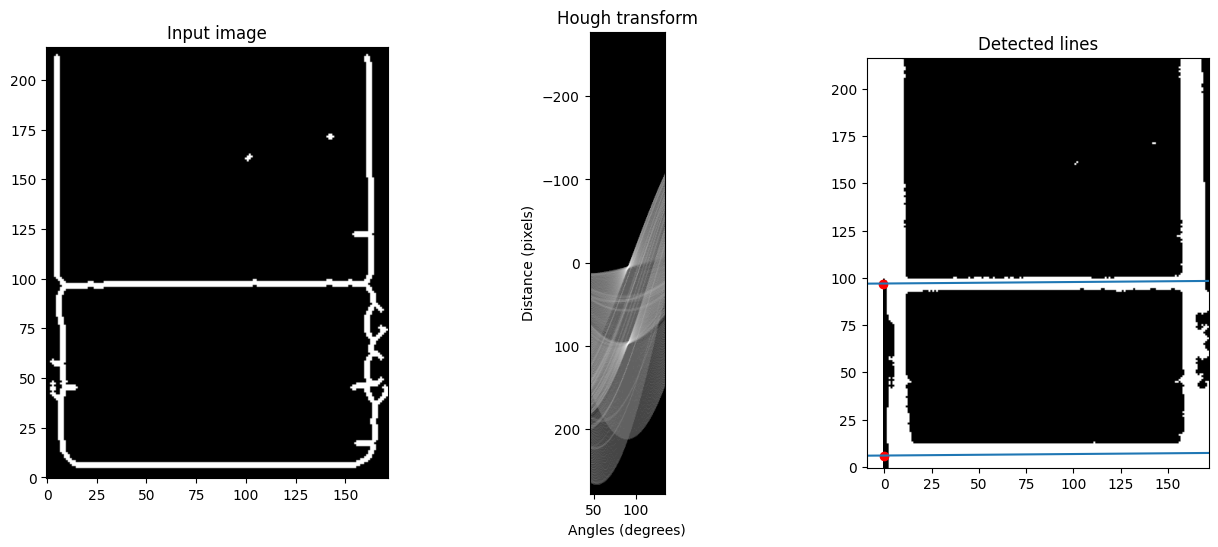

In [12]:
from skimage.morphology import medial_axis, skeletonize, binary_closing, thin, binary_dilation
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib import cm



from glob import glob
from natsort import natsorted
for folder in ["1/","2/","3/","4/","6/"]:
    dictionary_res={} # empty dictionary for the folder
    for file in natsorted(glob(f"{folder}*.pcd")):
        file_dict = {
                    "poles":{},
                    "boards":{}
                }
        print(f"-------!!!!!!!!!{file}!!!!!!!!!-------")
        im = do_raster(file)
        # im = np.flipud(im)
        # im = binary_closing(im, iterations=5, structure=np.ones((2,2)))
        im = binary_closing(im)
        # im = binary_closing(im)
        # im = binary_closing(im)
        # im = binary_closing(im)
        # im = binary_closing(im)

        thinned= thin(im)

        # Compute the medial axis (skeleton) and the distance transform
        skel, distance = medial_axis(im, return_distance=True)

        # Compare with other skeletonization algorithms
        skeleton = skeletonize(im)
        skeleton_lee = skeletonize(im, method='lee')

        # Distance to the background for pixels of the skeleton
        dist_on_skel = distance * skel


        fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(im, cmap=plt.cm.gray, origin='lower')
        ax[0].set_title('original')
        ax[0].axis('off')

        ax[1].imshow(dist_on_skel, cmap='magma',origin='lower')
        ax[1].contour(im, [0.5], colors='w')
        ax[1].set_title('medial_axis')
        ax[1].axis('off')

        ax[2].imshow(skeleton, cmap=plt.cm.gray,origin='lower')
        ax[2].set_title('skeletonize')
        ax[2].axis('off')

        ax[3].imshow(skeleton_lee, cmap=plt.cm.gray,origin='lower')
        ax[3].set_title("skeletonize (Lee 94)")
        ax[3].axis('off')

        ax[4].imshow(thinned, cmap=plt.cm.gray,origin='lower')
        ax[4].set_title("thinned")
        ax[4].axis('off')
        with open(f"bim_props.json") as f:
            bim_properties_dict = json.load(f)

        N_poles = bim_properties_dict[folder]['num_poles']
        N_boards =bim_properties_dict[folder]['num_boards']
        print(f"Looking for {N_poles} poles")
        poles=perform_hough(binary_dilation(thinned),im, -45,45,90,N_poles,15)
        print(f"Looking for {N_boards} Boards")
        boards = perform_hough(binary_dilation(thinned), im, 45,135,100,N_boards , 15)
    




        res = np.zeros(shape=im.shape)
    

        for idx_hough,pole in enumerate(poles):
            file_dict['poles'][f"{idx_hough}"] ={}
            temp = search_along_line(pole[0],pole[1],pole[2],im.astype(np.uint8))
            indexes = np.sort(np.where(temp>0))
            sets =[]
            try:
                start = [indexes[0][0], indexes[1][0]]

                print(f"len: {len(indexes[0])}")
                for idx in range(0,len(indexes[0])-1):
                    if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                        end= [indexes[0][idx], indexes[1][idx]]
                        sets.append([start, end])
                        start = [indexes[0][idx+1], indexes[1][idx+1]]
                end= [indexes[0][idx], indexes[1][idx]]
                sets.append([start, end])
                print(sets)
                for set_id,set in enumerate(sets):
                    if float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))> 50.0:
                        pole_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                        file_dict['poles'][f"{idx_hough}"][f"{set_id}"] = pole_dict
                        print(f"found a pole from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")

                # mean = np.mean(temp)
                x_min = np.min(indexes[1])
                x_max = np.max(indexes[1])
                y_min = np.min(indexes[0])
                y_max = np.max(indexes[0])
            except ValueError:
                print("No railing found")
                continue
            except IndexError as IE:
                print("No railing found")
                continue
            print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
            res = np.logical_or(temp>0, res)


            # break
        print("Looking for Boards")
        # boards = perform_hough(im, 60,120,int(60/1), 3,15)
        
        for idx_hough, board in enumerate(boards):
            file_dict['boards'][f"{idx_hough}"] ={}
            temp = search_along_line(board[0]+np.pi,board[1],board[2],im.astype(np.uint8))
            indexes = np.sort(np.where(temp>0))
            sets =[]
            try: 
                start = [indexes[0][0], indexes[1][0]]
                print(f"len: {len(indexes[0])}")
                for idx in range(0,len(indexes[0])-1):
                    if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                        end= [indexes[0][idx], indexes[1][idx]]
                        sets.append([start, end])
                        start = [indexes[0][idx+1], indexes[1][idx+1]]
                end= [indexes[0][idx], indexes[1][idx]]
                sets.append([start, end])
                print(sets)
                for set_id,set in enumerate(sets):
                    if float(np.linalg.norm((np.array([set[1]])-np.array([set[0]])))) > 60.0: # temp solution
                        board_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                        file_dict['boards'][f"{idx_hough}"][f"{set_id}"] = board_dict
                        print(f"found a board from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")
                # indexes = np.where(temp>np.mean(temp[np.where(temp>0)]))
            
                x_min = np.min(indexes[1])
                x_max = np.max(indexes[1])
                y_min = np.min(indexes[0])
                y_max = np.max(indexes[0])
            except ValueError:
                print("No railing found")
                continue
            except IndexError as IE:
                print("No railing found")
                continue
            print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
            res = np.logical_or(temp>0, res)
        ax[5].imshow(res, cmap=plt.cm.gray,origin='lower')
        ax[5].set_title("result")
        ax[5].axis('off')
        # plt.colorbar()
        # fig.tight_layout()
        plt.show()
        # plt.show()
        dictionary_res[file] = file_dict


    import json
    with open(f"{folder}result.json", 'w+') as f:
        f.write(json.dumps(dictionary_res, indent=4))

    instance = 0
    with open(f"{folder}result.json") as f:
        dict = json.load(f)

    with open(f"bim_props.json") as f:
        bim_properties_dict = json.load(f)
    string= ""
    string += "% object(FILE_ID, Instance_id, Type, seg(START_X, START_Y, END_X, END_Y)).\n"
    # string += "% board(FILE_ID, instance, seg(START_X, START_Y, END_X, END_Y)).\n"
    string += "% file_record(FILE, FILE_ID).\n"
    string += "% CONSTANTS\n"
    string += "parallel_margin(0.005).\n"
    string += "length_margin(20).\n"

    string += "% FILE_RECORDS\n"
    for id,[file, obj] in enumerate(dict.items()):
        string += f"file_record(\"{file}\", {id}).\n"
    
    string += "% BIM_PROPERTIES\n"
    for id,[file, obj] in enumerate(dict.items()):
        string += f"railing_length({id}, {bim_properties_dict[folder]['railing_length']}).\n"
    for id,[file, obj] in enumerate(dict.items()):
        string += f"railing_height({id}, {bim_properties_dict[folder]['railing_height']}).\n"
    for id,[file, obj] in enumerate(dict.items()):
        string += f"min_num_poles({id}, {bim_properties_dict[folder]['num_poles']}).\n"
    for id,[file, obj] in enumerate(dict.items()):
        string += f"min_num_boards({id}, {bim_properties_dict[folder]['num_boards']}).\n"
    for id,[file, obj] in enumerate(dict.items()):
        # print(obj)
        for hough in obj['poles'].values():
            for pole in hough.values():
                # print(pole['start']['x'])
                string += f"object({id}, {instance}, pole, seg({pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']})).\n"
                instance +=1
    for id, [file, obj] in enumerate(dict.items()):  
        for hough in obj['boards'].values():
            for board in hough.values():
                string += f"object({id}, {instance}, board, seg({board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']})).\n"
                instance +=1
    with open(f"{folder}knowledge.pl", 'w+') as f:
        f.write(string)